# Master's thesis case study 3: Bandit's with stopping

In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
import numpy
import torch
from adaptive_nof1 import *
from adaptive_nof1.policies import *
from adaptive_nof1.helpers import *
from adaptive_nof1.inference import *
from adaptive_nof1.metrics import *
from matplotlib import pyplot as plt

In [3]:
# Setup generic n-of-1 parameters

length = 6
number_of_actions = 3
number_of_patients = number_of_actions ** (length - number_of_actions) * 100

In [4]:
# In this case study, we assume a know variance of 1 and three independent variables.
# Our data generating model can therefore be expressed as a multivariate normal with \eye as the covariance matrics
class MultivariateNormal(Model):
    def __init__(self, patient_id):
        self.rng = numpy.random.default_rng(patient_id)
        self.mu = [0.0, 1.0, 1.0]
        self.patient_id = patient_id
        self.distribution = torch.distributions.MultivariateNormal(torch.tensor(self.mu), torch.eye(len(self.mu)))

    @property
    def additional_config(self):
        return {"expectations_of_interventions": self.mu}
 
    
    def generate_context(self, history):
        return {}

    def observe_outcome(self, intervention, context):
        return {"outcome": self.distribution.sample()[intervention["treatment"]].item()}

    def __str__(self):
        return f"MultivariateNormal {self.mu}"

data_generating_model = lambda patient_id: MultivariateNormal(patient_id)

In [5]:
from adaptive_nof1 import SeriesOfSimulationsRunner
from adaptive_nof1.policies import FixedIndexedPolicy, FrequentistEpsilonGreedy, ConstantPolicy
from adaptive_nof1.inference import NormalKnownVariance

fixed_schedule_runner = SeriesOfSimulationsRunner(
    model_from_patient_id=data_generating_model,
    n_patients=number_of_patients,
    policy=FixedIndexedPolicy(number_of_actions=number_of_actions,
                              inference=NormalKnownVariance(
                                  variance=1,
    )
    ),
)

fixed_schedule_data = fixed_schedule_runner.simulate(length)

  0%|          | 0/6 [00:00<?, ?it/s]

In [5]:
from adaptive_nof1.metrics import *
from adaptive_nof1.series_of_simulations_data import SeriesOfSimulationsData

def debug_data_to_torch_distribution(debug_data):
    mean = debug_data["mean"]
    variance = debug_data["variance"]
    cov = torch.diag_embed(torch.tensor(variance))
    return torch.distributions.MultivariateNormal(torch.tensor(mean), cov)

SeriesOfSimulationsData.plot_lines(
    [fixed_schedule_data],
    [
        SimpleRegretWithMean(),
        CumulativeRegret(),
        KLDivergence(true_distribution = MultivariateNormal(0).distribution, debug_data_to_distribution=debug_data_to_torch_distribution)
    ],
    legend_position=(1,1),
)

NameError: name 'fixed_schedule_data' is not defined

In [ ]:
fixed_schedule_data.plot_allocations()

In [ ]:
from adaptive_nof1.helpers import index_to_value_counts

df = SeriesOfSimulationsData.score_data(
    [fixed_schedule_data],
    [SimpleRegretWithMean(), CumulativeRegret(), KLDivergence(true_distribution = MultivariateNormal(0).distribution, debug_data_to_distribution=debug_data_to_torch_distribution)],
)

df = df.loc[df["t"] == df["t"].max()]
df["id"] = df["patient_id"].astype(int).mod(number_of_actions ** (length - number_of_actions))
df["allocations"] = df["patient_id"].apply(lambda x: index_to_values([3,3,3], int(x)))
df.set_index(["patient_id", "metric"]).groupby(["id", "metric"])["score"].mean().unstack()
groupby = df.set_index(["patient_id", "metric"]).groupby(["id", "metric"])["score"].mean().unstack()
groupby["allocations"] = groupby.index.to_frame()["id"].apply(lambda x: index_to_value_counts([3,3,3], int(x)))
groupby = pd.concat([groupby, pd.DataFrame(groupby['allocations'].tolist())], axis=1)
groupby

## These are no value counts these are just copies :/

In [ ]:
# Interesting obervation: We do not need all of these indices, since we can reduce our problem to the number each element was picked.

## Simulation Study

In [4]:
# Initial parameters
block_length = 5
max_length = 20 * block_length
number_of_actions = 2
number_of_patients = 100

In [5]:
# Scenarios
class NormalModel(Model):
    def __init__(self, patient_id, mean, variance):
        self.rng = numpy.random.default_rng(patient_id)
        self.mean = mean
        self.variance = variance
        self.patient_id = patient_id

    def generate_context(self, history):
        return {}

    @property
    def additional_config(self):
        return {"expectations_of_interventions": self.mean}

    def observe_outcome(self, action, context):
        treatment_index = action["treatment"]
        return {"outcome": self.rng.normal(self.mean[treatment_index], self.variance[treatment_index])}

    def __str__(self):
        return f"NormalModel({self.mean, self.variance})"

generating_scenario_I = lambda patient_id: NormalModel(patient_id, mean=[0, 0], variance=[1,1])
generating_scenario_II = lambda patient_id: NormalModel(patient_id, mean=[1, 0], variance=[1,1])
generating_scenario_III = lambda patient_id: NormalModel(patient_id, mean=[2, 0], variance=[1,1])
generating_scenario_IV = lambda patient_id: NormalModel(patient_id, mean=[1, 0, 0], variance=[1,1,1])
generating_scenario_V = lambda patient_id: NormalModel(patient_id, mean=[2, 1, 0], variance=[1,1,1])

In [6]:
# Inference Model
inference_model = lambda: NormalKnownVariance(prior_mean=0, prior_variance=1, variance=1)

# Stopping Time
ALPHA_STOPPING = 0.05
def alpha_stopping_time(history, context):
    model = NormalKnownVariance(prior_mean=0, prior_variance=1, variance=1)
    model.update_posterior(history, number_of_actions)
    probabilities = model.approximate_max_probabilities(number_of_actions, context)
    return 1 - max(probabilities) < ALPHA_STOPPING

In [14]:
# Policies

fixed_policy = StoppingPolicy(
    policy= BlockPolicy(
        block_length = block_length,
        internal_policy = FixedPolicy(
        number_of_actions=2,
        inference_model = inference_model(),
    ),
    ),
    stopping_time = alpha_stopping_time,
)  


thompson_sampling_policy = StoppingPolicy(
        policy= BlockPolicy(
            block_length = block_length,
            internal_policy = ThompsonSampling(
                inference_model=inference_model(),
                number_of_actions=2,
            ),
        ),
    stopping_time = alpha_stopping_time,
)

ucb_policy = StoppingPolicy(
    policy = BlockPolicy(
        block_length = block_length,
        internal_policy = UpperConfidenceBound(
            inference_model=inference_model(),
            number_of_actions=2,
            epsilon=0.05,
        ),
    ),
    stopping_time = alpha_stopping_time,
)

In [26]:
# Full crossover study
study_designs = {
    "n_patients": [number_of_patients],
    "policy": [fixed_policy, thompson_sampling_policy, ucb_policy],
    #"model_from_patient_id": [
    #    generating_scenario_I, generating_scenario_II, generating_scenario_III, generating_scenario_IV, generating_scenario_V,
    #],
    "model_from_patient_id": [
        generating_scenario_I, generating_scenario_II,
    ]
}
configurations = generate_configuration_cross_product(study_designs)

In [27]:
calculated_series, config_to_simulation_data = simulate_configurations(
    configurations, max_length
)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [28]:
# Todo: make the output table in a way that we chose the maximum index

metrics = [
    SimpleRegretWithMean(),
    CumulativeRegret(),
    #KLDivergence(true_distribution = MultivariateNormal(0).distribution, debug_data_to_distribution=debug_data_to_torch_distribution)
]
model_mapping = {
    "NormalModel(([0, 0], [1, 1]))": "Scenario I",
    "NormalModel(([1, 0], [1, 1]))": "Scenario II",
    "NormalModel(([2, 0], [1, 1]))": "Scenario III",
    "NormalModel(([1, 0, 0], [1, 1, 1]))": "Scenario IV",
    "NormalModel(([2, 1, 0], [1, 1, 1]))": "Scenario V", 
}
policy_mapping = {
    "StoppingPolicy(BlockPolicy(FixedPolicy))": "Fixed",
    "StoppingPolicy(BlockPolicy(ThompsonSampling(NormalKnownVariance(0, 1, 1))))": "Thompson Sampling",
    "StoppingPolicy(BlockPolicy(UpperConfidenceBound: 0.05 epsilon))": "Upper Confidence Bounds",
}

df = SeriesOfSimulationsData.score_data(
    [s["result"] for s in calculated_series], metrics, {"model": lambda x: model_mapping[x], "policy": lambda x: policy_mapping[x]}
)
filtered_df = df.loc[df["t"] == df["t"].max()]
filtered_df

groupby_columns = ["model", "policy"]
pivoted_df = filtered_df.pivot(
    index=["model", "policy", "simulation", "patient_id"],
    columns="metric",
    values="score",
)
table = pivoted_df.groupby(groupby_columns).agg(['mean', 'std'])

table

metric                        Cumulative Regret     Simple Regret With Mean  \
                                           mean std                    mean   
model       policy                                                            
Scenario II Thompson Sampling       -105.738559 NaN                     0.0   

metric                             
                              std  
model       policy                 
Scenario II Thompson Sampling NaN

In [29]:
with open('mt_resources/7-stopping/01-table.tex', 'w') as file:
    file.write(table.style.format(precision=2).to_latex())

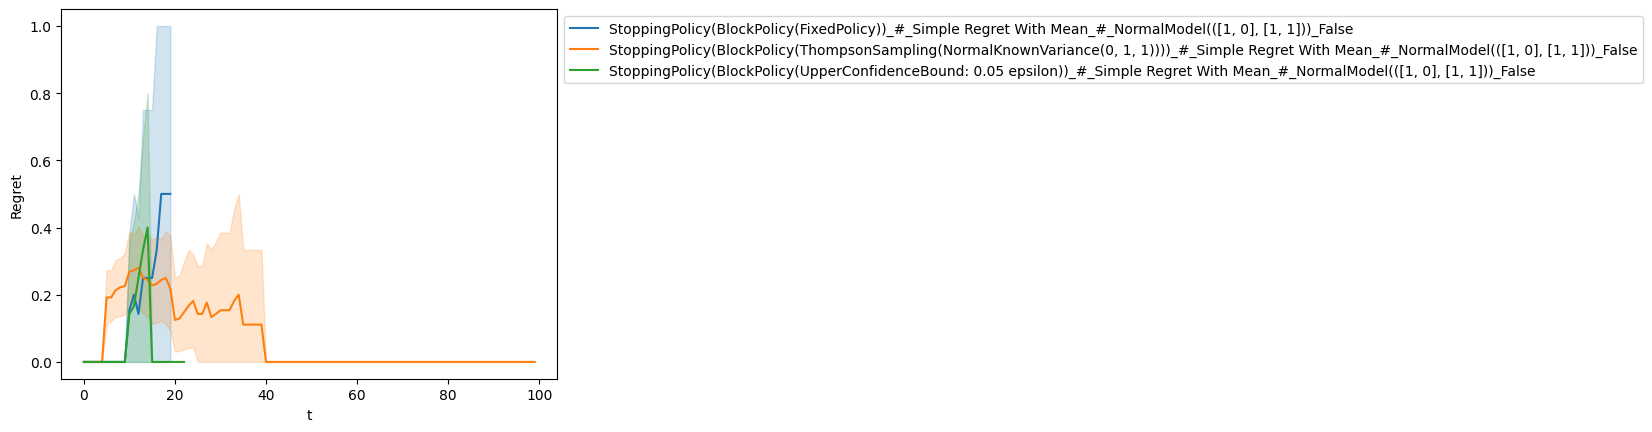

In [30]:
SeriesOfSimulationsData.plot_lines(
    [s["result"] for s in calculated_series if s["configuration"]["model"] == "NormalModel(([1, 0], [1, 1]))"],
    [
        SimpleRegretWithMean(),
        #KLDivergence(true_distribution = MultivariateNormal(0).distribution, debug_data_to_distribution=debug_data_to_torch_distribution)
    ],
    legend_position=(1,1),
)
plt.savefig("mt_resources/5-optimization/02_simple_regret.pdf", bbox_inches="tight")

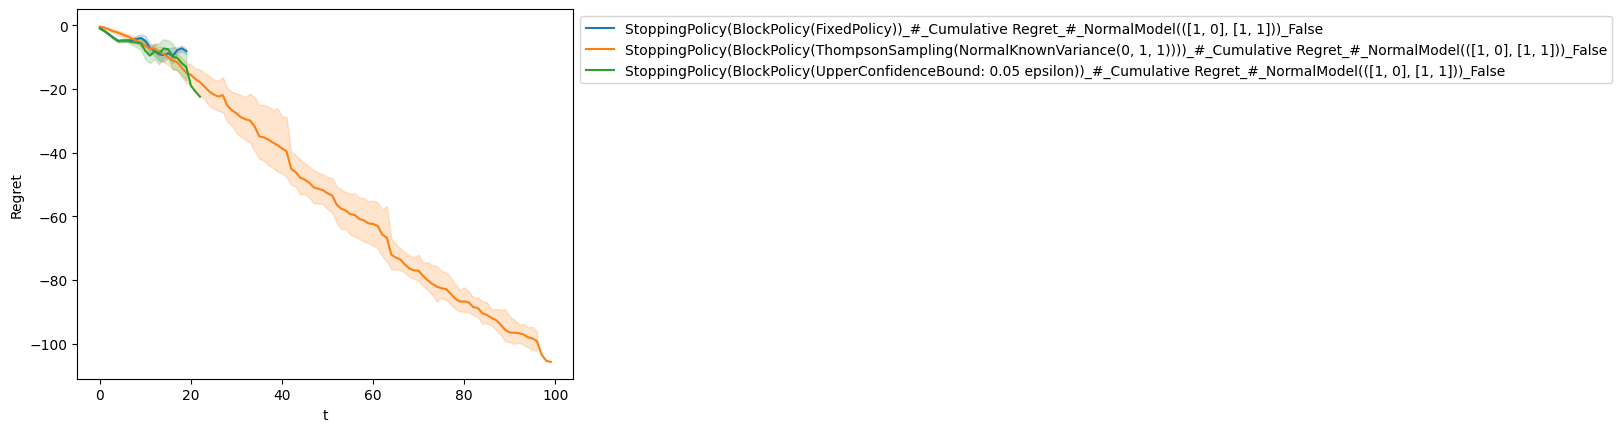

In [31]:
SeriesOfSimulationsData.plot_lines(
    [s["result"] for s in calculated_series if s["configuration"]["model"] == "NormalModel(([1, 0], [1, 1]))"],
    [
        CumulativeRegret(),
        #KLDivergence(true_distribution = MultivariateNormal(0).distribution, debug_data_to_distribution=debug_data_to_torch_distribution)
    ],
    legend_position=(1,1),
)
plt.savefig("mt_resources/5-optimization/02_cumulative_regret.pdf", bbox_inches="tight")

In [32]:
plot_allocations_for_calculated_series(calculated_series)

/opt/homebrew/Caskroom/miniconda/base/envs/mt/lib/python3.11/site-packages/holoviews/plotting/bokeh/plot.py:987: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  layout_plot = gridplot(
/opt/homebrew/Caskroom/miniconda/base/envs/mt/lib/python3.11/site-packages/holoviews/plotting/bokeh/plot.py:987: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  layout_plot = gridplot(


:Layout
   .HeatMap.I   :HeatMap   [t,patient_id]   (treatment,debug_info,context,outcome,counterfactual_outcomes,debug_data,treatment)
   .HeatMap.II  :HeatMap   [t,patient_id]   (treatment,debug_info,context,outcome,counterfactual_outcomes,debug_data,treatment)
   .HeatMap.III :HeatMap   [t,patient_id]   (treatment,debug_info,context,outcome,counterfactual_outcomes,debug_data,treatment)
   .HeatMap.IV  :HeatMap   [t,patient_id]   (treatment,debug_info,context,outcome,counterfactual_outcomes,debug_data,treatment)
   .HeatMap.V   :HeatMap   [t,patient_id]   (treatment,debug_info,context,outcome,counterfactual_outcomes,debug_data,treatment)
   .HeatMap.VI  :HeatMap   [t,patient_id]   (treatment,debug_info,context,outcome,counterfactual_outcomes,debug_data,treatment)